In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import f1_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA, KernelPCA
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, learning_curve, validation_curve
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE

In [64]:
plt.rc('font', family='Malgun Gothic')

In [2]:
from matplotlib.colors import ListedColormap

def plot_decision_regions(X, y, classifier, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    #print(xx1)
    #print(xx2)
    #print(np.array([xx1.ravel(), xx2.ravel()]).T)
    
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                    alpha=0.8, c=cmap(idx),
                    edgecolor='black',
                    marker=markers[idx], 
                    label=cl)

In [54]:
app = pd.read_csv('application_record.csv')
credit = pd.read_csv('credit_record.csv')
credit['STATUS'].value_counts()

STATUS
C    442031
0    383120
X    209230
1     11090
5      1693
2       868
3       320
4       223
Name: count, dtype: int64

In [55]:
# credit.drop('MONTHS_BALANCE', axis=1, inplace=True)
# credit['STATUS'].replace({'C': 0, 'X' : 0}, inplace=True)
# credit['STATUS'] = credit['STATUS'].astype('int')
# credit['STATUS'] = credit['STATUS'].apply(lambda x: 1 if x >= 1 else 0)
# credit_gb = credit.groupby('ID').max()
# credit_gb
credit.drop('MONTHS_BALANCE', axis=1, inplace=True)
credit['STATUS'] = credit['STATUS'].map({'C':0,'X':0,'0':1,'1':2,'2':3,'3':4,'4':5,'5':6})
credit_gb = credit.groupby('ID').sum()['STATUS']
credit_gb = credit_gb.apply(lambda x: 1 if x >= 15 else 0)
credit_gb

ID
5001711    0
5001712    0
5001713    0
5001714    0
5001715    0
          ..
5150482    0
5150483    0
5150484    0
5150485    0
5150487    0
Name: STATUS, Length: 45985, dtype: int64

In [57]:
credit_gb.value_counts()

STATUS
0    37719
1     8266
Name: count, dtype: int64

In [102]:
# credit['STATUS'] = credit['STATUS'].map({'C':0, 'X':0, '0':0, '1':0, '2':1, '3':1, '4':1, '5':1})

In [58]:
df = pd.merge(app, credit_gb, on='ID', how='inner')
df = df.set_index('ID')

In [59]:
df['DAYS_BIRTH'] = abs(df['DAYS_BIRTH'] // 365)
df['DAYS_EMPLOYED'] = abs(df['DAYS_EMPLOYED'].apply(lambda x: 0 if x == 365243 else x) // 365)
df['CODE_GENDER'] = df['CODE_GENDER'].map({'M':0, 'F':1})
df['FLAG_OWN_CAR'] = df['FLAG_OWN_CAR'].map({'N':0, 'Y':1})
df['FLAG_OWN_REALTY'] = df['FLAG_OWN_REALTY'].map({'N':0, 'Y':1})

df.drop('OCCUPATION_TYPE', axis=1, inplace=True)

In [60]:

# df.loc[:, 'NAME_INCOME_TYPE'] = df['NAME_INCOME_TYPE'].map({'Working':0, 'Commercial associate':1, 'Pensioner':2, 'State servant':3, 'Student':4})
# df.loc[:, 'NAME_EDUCATION_TYPE'] = df['NAME_EDUCATION_TYPE'].map({'Secondary / secondary special':0, 'Higher education':1, 'Incomplete higher':2,
#                                  'Lower secondary':3, 'Academic degree':4})
# df.loc[:, 'NAME_HOUSING_TYPE'] = df['NAME_HOUSING_TYPE'].map({'House / apartment':0, 'With parents':1, 'Municipal apartment':2, 
#                               'Rented apartment':3, 'Office apartment':4, 'Co-op apartment':5})
# df.loc[:, 'NAME_FAMILY_STATUS'] = df['NAME_FAMILY_STATUS'].map({'Married':0, 'Single / not married':1, 
#                                                                 'Civil marriage':2, 'Separated':3, 'Widow':4})
df

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,STATUS
ID,,,,,,,,,,,,,,,,,
5008804,0,1,1,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,33,13,1,1,0,0,2.0,0
5008805,0,1,1,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,33,13,1,1,0,0,2.0,0
5008806,0,1,1,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,59,4,1,0,0,0,2.0,0
5008808,1,0,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,53,9,1,0,1,1,1.0,0
5008809,1,0,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,53,9,1,0,1,1,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5149828,0,1,1,0,315000.0,Working,Secondary / secondary special,Married,House / apartment,48,7,1,0,0,0,2.0,1
5149834,1,0,1,0,157500.0,Commercial associate,Higher education,Married,House / apartment,34,4,1,0,1,1,2.0,1
5149838,1,0,1,0,157500.0,Pensioner,Higher education,Married,House / apartment,34,4,1,0,1,1,2.0,1


In [61]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

# train/valid/test 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

# 그래프

In [14]:
def corr(x, y, **kwargs):
    # 상관계수를 계산합니다.
    coef = np.corrcoef(x, y)[0][1]
    # 상관계수를 문자열로 바꿉니다.
    label = r'$\rho$ = ' + str(round(coef, 2))
    # 상관계수를 그래프 상단에 표시합니다.
    ax = plt.gca()
    ax.annotate(label, xy = (0.2, 0.95), size = 20, xycoords = ax.transAxes)

# pairplot을 그립니다.
g = sns.PairGrid(X_train)

# 대각선 아래쪽에는 산점도를 그립니다.
g.map_lower(sns.scatterplot, color = 'blue')

# 대각선 위쪽에는 상관계수를 표시합니다.
g.map_upper(corr)

# 대각선에는 히스토그램을 그립니다.
g.map_diag(sns.histplot, color = 'blue')

plt.show()

AttributeError: 'float' object has no attribute 'shape'

Error in callback <function _draw_all_if_interactive at 0x000001562C675C60> (for post_execute):


KeyboardInterrupt: 

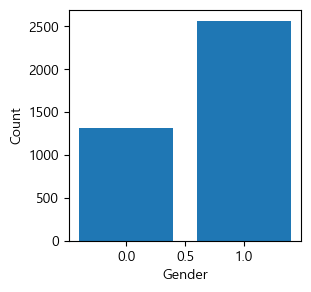

In [65]:
# y_train이 1인 행만 선택
mask = y_train == 1
selected_X_train = X_train[mask]

# 카테고리별로 개수 세기
gender_counts = selected_X_train['CODE_GENDER'].value_counts()

# 막대그래프 그리기
plt.figure(figsize=(3, 3))
plt.bar(gender_counts.index, gender_counts.values)
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

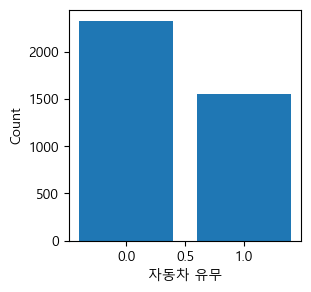

In [66]:
# y_train이 1인 행만 선택
mask = y_train == 1
selected_X_train = X_train[mask]

# 카테고리별로 개수 세기
gender_counts = selected_X_train['FLAG_OWN_CAR'].value_counts()

# 막대그래프 그리기
plt.figure(figsize=(3, 3))
plt.bar(gender_counts.index, gender_counts.values)
plt.xlabel('자동차 유무')
plt.ylabel('Count')
plt.show()

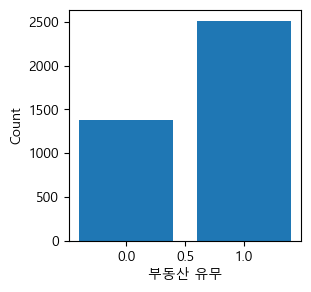

In [67]:
# y_train이 1인 행만 선택
mask = y_train == 1
selected_X_train = X_train[mask]

# 카테고리별로 개수 세기
gender_counts = selected_X_train['FLAG_OWN_REALTY'].value_counts()

# 막대그래프 그리기
plt.figure(figsize=(3, 3))
plt.bar(gender_counts.index, gender_counts.values)
plt.xlabel('부동산 유무')
plt.ylabel('Count')
plt.show()

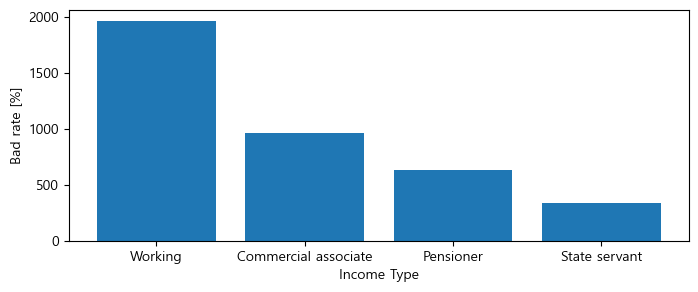

In [68]:
# y_train이 1인 행만 선택
mask = y_train == 1
selected_X_train = X_train[mask]

# 카테고리별로 개수 세기
gender_counts = selected_X_train['NAME_INCOME_TYPE'].value_counts()

# 막대그래프 그리기
plt.figure(figsize=(8, 3))
plt.bar(gender_counts.index, gender_counts.values)
plt.xlabel('Income Type')
plt.ylabel('Bad rate [%]')
plt.show()

In [ ]:
plt.figure(figsize=(10,6))
sns.countplot(x='NAME_INCOME_TYPE', hue='STATUS', data=df)
plt.title('직업별 STATUS 분포')
plt.show()

In [ ]:
plt.figure(figsize=(10,6))
sns.countplot(x='NAME_EDUCATION_TYPE', hue='STATUS', data=df)
plt.title('학력별 STATUS 분포')
plt.show()

In [ ]:
plt.figure(figsize=(10,6))
sns.countplot(x='NAME_FAMILY_STATUS', hue='STATUS', data=df)
plt.title('결혼 유무별 STATUS 분포')
plt.show()

In [ ]:
plt.figure(figsize=(10,6))
sns.countplot(x='NAME_HOUSING_TYPE', hue='STATUS', data=df)
plt.title('집 형태별 STATUS 분포')
plt.show()

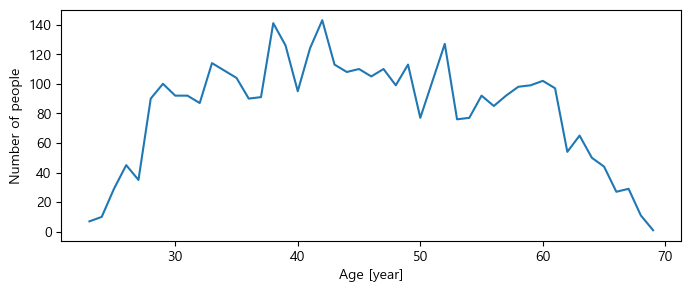

In [69]:
# byage = df.groupby('DAYS_BIRTH')['STATUS'].mean()

# plt.figure(figsize=(8, 3))
# plt.plot(byage)
# plt.xlabel('Age [year]')
# plt.ylabel('Bad rate [%]')
# plt.show()

# 카테고리별로 개수 세기
birth_counts = selected_X_train['DAYS_BIRTH'].value_counts().sort_index()

# 나이로 변환 (-1을 곱한 후, 365.25로 나누기)
age_counts = birth_counts.index

# 막대그래프 그리기
plt.figure(figsize=(8, 3))
plt.plot(age_counts, birth_counts.values)
plt.xlabel('Age [year]')
plt.ylabel('Number of people')
plt.show()


In [ ]:
bins = [0, 5, 10, 15, 20, 25, 30, 35, 40]
labels = [0, 5, 10, 15, 20, 25, 30, 35 ]
df['DAYS_EMPLOYED'] = pd.cut(df['DAYS_EMPLOYED'], bins=bins, labels=labels, right=False)

plt.figure(figsize=(10,6))
sns.countplot(x='DAYS_EMPLOYED', hue='STATUS', data=df)
plt.title('근속년수별 STATUS 분포')
plt.show()

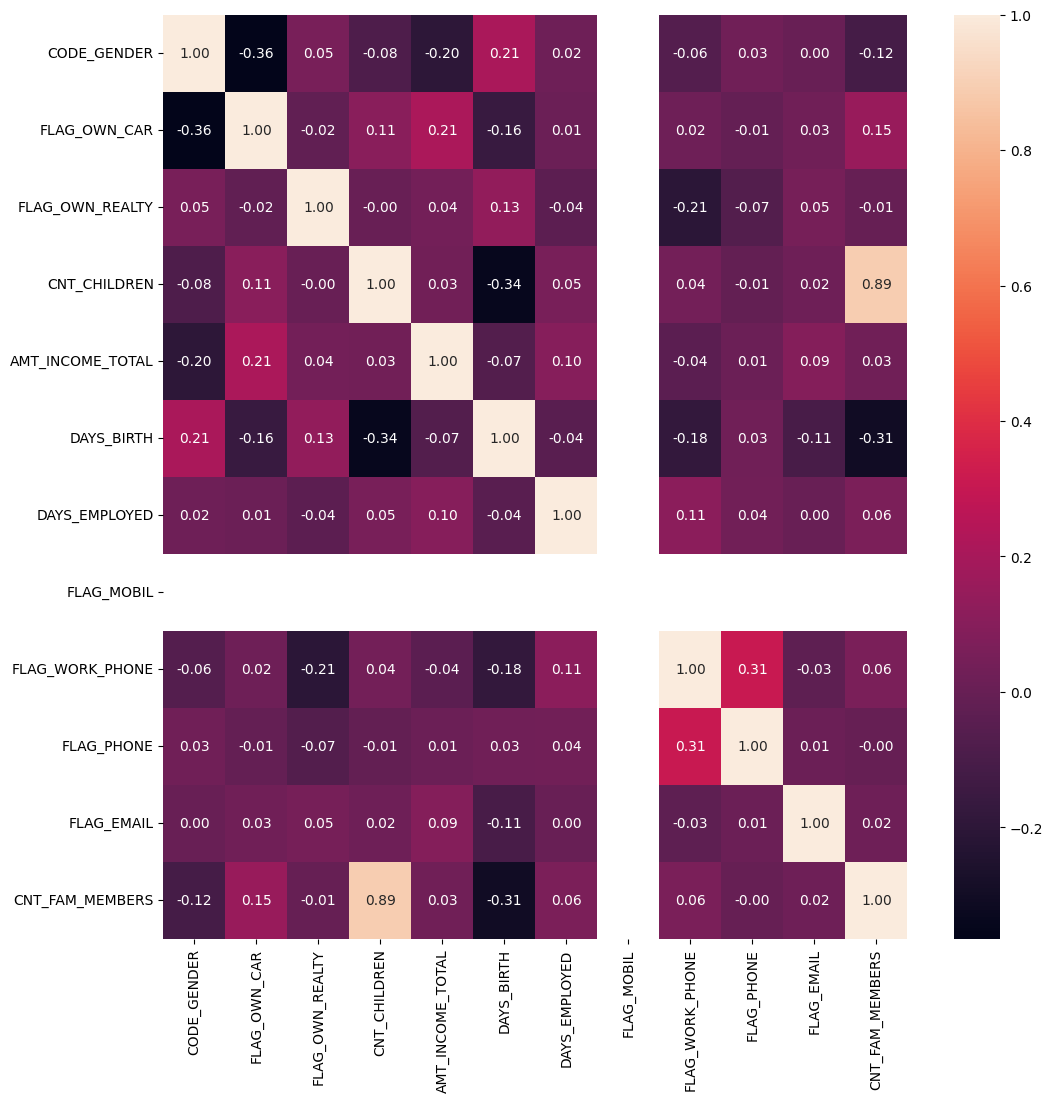

In [41]:
plt.figure(figsize=(12,12))
sns.heatmap(X_train.corr(numeric_only=True), annot=True, fmt='.2f')
plt.show()

# 인코딩

In [72]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

for column in ['NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE']:
    X_train[column] = encoder.fit_transform(X_train[column])
for column in ['NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE']:
    X_test[column] = encoder.fit_transform(X_test[column])
for column in ['NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE']:
    X_val[column] = encoder.fit_transform(X_val[column])

# 소수 클래스 오버스케일링
sampler = SMOTE(sampling_strategy=0.5)
X_train, y_train = sampler.fit_resample(X_train, y_train)
X_test, y_test = sampler.fit_resample(X_test, y_test)
X_val, y_val = sampler.fit_resample(X_val, y_val)

X_train


,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS
0,1,0,1,0,81000.0,1,4,1,1,60,0,1,0,1,0,2.000000
1,1,0,1,1,202500.0,4,4,1,1,39,1,1,0,0,0,3.000000
2,1,0,1,0,90000.0,4,4,1,2,49,16,1,0,0,0,2.000000
3,0,0,1,0,148500.0,4,1,2,1,34,4,1,0,1,1,1.000000
4,0,0,1,0,180000.0,1,4,0,1,65,0,1,0,0,0,2.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29162,0,0,0,0,202500.0,1,4,1,1,23,3,1,1,0,0,2.000000
29163,1,0,0,0,121500.0,2,1,0,1,59,16,1,0,0,0,2.000000
29164,0,0,0,0,135000.0,4,4,1,1,29,4,1,1,0,0,2.174429
29165,0,1,0,0,135000.0,0,4,1,1,29,1,1,0,0,0,1.743817


In [93]:
# X_train.drop(['FLAG_PHONE', 'CNT_CHILDREN', 'NAME_HOUSING_TYPE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 
#               'FLAG_MOBIL', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'FLAG_WORK_PHONE'], axis=1, inplace=True)
# X_test.drop(['FLAG_PHONE', 'CNT_CHILDREN', 'NAME_HOUSING_TYPE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 
#               'FLAG_MOBIL', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'FLAG_WORK_PHONE'], axis=1, inplace=True)
# X_val.drop(['FLAG_PHONE', 'CNT_CHILDREN', 'NAME_HOUSING_TYPE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 
#               'FLAG_MOBIL', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'FLAG_WORK_PHONE'], axis=1, inplace=True)
# X_train

# 특성 선택

In [73]:
from sklearn.ensemble import RandomForestClassifier

# forest = RandomForestClassifier(criterion='gini', max_depth=4, n_estimators=25, random_state=1, n_jobs=-1)
forest = RandomForestClassifier(n_estimators=100, random_state=1)
forest.fit(X_train, y_train)

RandomForestClassifier(random_state=1)

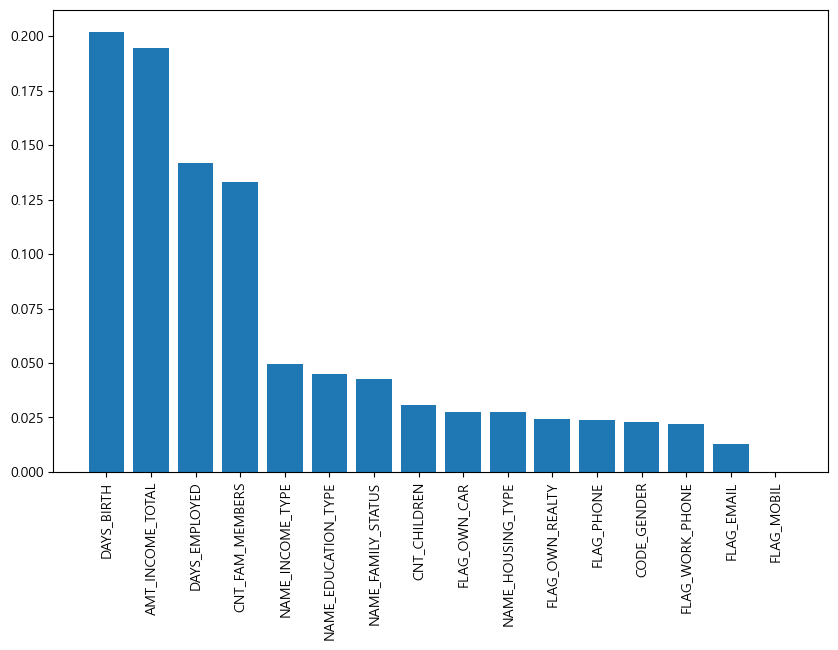

In [74]:
ipt = forest.feature_importances_
idxs = np.argsort(ipt)[::-1] # 역순

plt.figure(figsize=(10,6))
plt.bar(np.array(X_train.columns)[idxs], ipt[idxs]) # ipt[idxs 중요도
plt.xticks(rotation=90)
plt.show()

In [75]:
X_train = X_train[['CODE_GENDER', 'AMT_INCOME_TOTAL', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'DAYS_BIRTH', 'DAYS_EMPLOYED']]
X_test = X_test[['CODE_GENDER', 'AMT_INCOME_TOTAL', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'DAYS_BIRTH', 'DAYS_EMPLOYED']]
X_val = X_val[['CODE_GENDER', 'AMT_INCOME_TOTAL', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'DAYS_BIRTH', 'DAYS_EMPLOYED']]

# 스케일링

In [76]:
X_train = X_train.copy()

std_scaler = StandardScaler()
std_columns = ['AMT_INCOME_TOTAL', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS']
X_train[std_columns] = std_scaler.fit_transform(X_train[std_columns])
X_val[std_columns] = std_scaler.transform(X_val[std_columns])
X_test[std_columns] = std_scaler.transform(X_test[std_columns])


mM_scaler = MinMaxScaler()
mM_columns = ['DAYS_BIRTH', 'DAYS_EMPLOYED']
X_train[mM_columns] = mM_scaler.fit_transform(X_train[mM_columns])
X_val[mM_columns] = mM_scaler.transform(X_val[mM_columns])
X_test[mM_columns] = mM_scaler.transform(X_test[mM_columns])

X_train


,CODE_GENDER,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,DAYS_BIRTH,DAYS_EMPLOYED
0,1,-1.036842,-0.796166,0.684552,-0.358810,0.808511,0.000000
1,1,0.131904,0.946338,0.684552,-0.358810,0.361702,0.022727
2,1,-0.950268,0.946338,0.684552,-0.358810,0.574468,0.363636
3,0,-0.387539,0.946338,-1.578008,0.719099,0.255319,0.090909
4,0,-0.084531,-0.796166,0.684552,-1.436719,0.914894,0.000000
...,...,...,...,...,...,...,...
29162,0,0.131904,-0.796166,0.684552,-0.358810,0.021277,0.068182
29163,1,-0.647260,-0.215331,-1.578008,-1.436719,0.787234,0.363636
29164,0,-0.517399,0.946338,0.684552,-0.358810,0.148936,0.090909
29165,0,-0.517399,-1.377000,0.684552,-0.358810,0.148936,0.022727


# 모델 선택

In [78]:
high_score = 0
best_model = None

for c in range(-3, 3):
    lr = LogisticRegression(solver='liblinear', C=10**c, random_state=1)
    model = lr.fit(X_train, y_train)
    p_val = lr.predict(X_val)
    score = f1_score(y_val, p_val)
    if score > high_score:
        high_score = score
        best_model = model
        
for i in range(6,25):
    forest = RandomForestClassifier(criterion='gini', max_depth=i, n_estimators=300, random_state=1, n_jobs=-1)
    model = forest.fit(X_train, y_train)
    p_val = forest.predict(X_val)
    score = f1_score(y_val, p_val)
    if score > high_score:
        high_score = score
        best_model = model

print('Best F1-score:', high_score)
best_model

Best F1-score: 0.5440781440781441


RandomForestClassifier(max_depth=24, n_estimators=300, n_jobs=-1,
                       random_state=1)

# 차원 축소

In [ ]:
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# lda = LDA(n_components=1)
# X_train_lda = lda.fit_transform(X_train_sc, y_train)

# # lda instance reference is used here
# X_test_lda = lda.transform(X_test_sc)

# plt.scatter(X_train_lda[y_train==0], np.zeros((np.sum(y_train==0),1)), color='red')
# plt.scatter(X_train_lda[y_train==1], np.zeros((np.sum(y_train==1),1)), color='blue')
# plt.show()


In [ ]:
# from sklearn.decomposition import KernelPCA, PCA

# pca = PCA(n_components=2)
# X_pca = pca.fit_transform(X_train_sc)

# plt.figure(figsize=(10,1))
# plt.scatter(X_pca[y_train==0,0], np.zeros_like(X_pca[y_train==0,0])) # np.zeros(X_pca[y==0,0].shape)
# plt.scatter(X_pca[y_train==1,0], np.zeros_like(X_pca[y_train==1,0]))
# plt.show()

In [ ]:
from sklearn.decomposition import KernelPCA

# 먼저 훈련 데이터에 대해서 fit_transform을 수행합니다.
pca = KernelPCA(n_components=2, kernel='rbf', gamma=30)
X_train_kpca = pca.fit_transform(X_train_sc)

# 그 후, 테스트 데이터에 대해서는 transform만 수행합니다.
X_test_kpca = pca.transform(X_test_sc)

# 그래프 그리기
plt.figure(figsize=(10,1))
plt.scatter(X_train_kpca[y_train==0,0], X_train_kpca[y_train==0,1]) 
plt.scatter(X_train_kpca[y_train==1,0], X_train_kpca[y_train==1,1])
plt.show()


# 교차검증

In [127]:
from sklearn.model_selection import cross_val_score
# 순서대로
lr_pipe = make_pipeline( 
                        
                        SVC(C=1, gamma=1, random_state=1))
# lr_pipe.fit(X_train, y_train)
# lr_pipe.predict(X_test)
cvscore = cross_val_score(estimator=lr_pipe, X=X_train, y=y_train, cv=10, n_jobs=-1) # 10조각(kfold)
print('\n교차검증(CV) 정확도 : ', np.mean(cvscore))
for i, j in enumerate(cvscore):
    print(f'{i+1}번 : {j}')


교차검증(CV) 정확도 :  0.8332762190412073
1번 : 0.8329048843187661
2번 : 0.8329048843187661
3번 : 0.8328332618945564
4번 : 0.833690527218174
5번 : 0.8345477925417917
6번 : 0.833690527218174
7번 : 0.8332618945563652
8번 : 0.8328332618945564
9번 : 0.8345477925417917
10번 : 0.8315473639091299


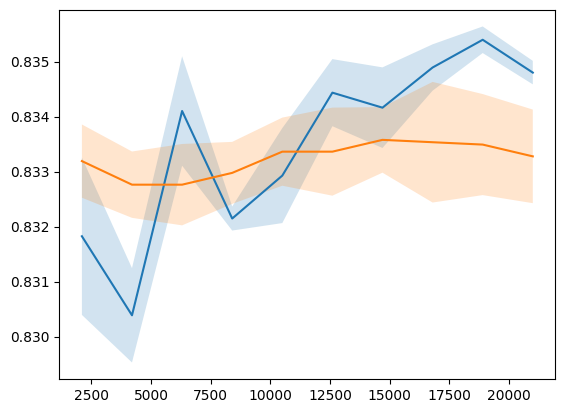

In [128]:
from sklearn.model_selection import learning_curve

sizes, train_score, val_score = learning_curve(estimator=lr_pipe, X=X_train, y=y_train, 
                                               train_sizes=np.linspace(0.1, 1.0, 10), cv=10, n_jobs=-1)

train_mean = np.mean(train_score, axis=1)
val_mean = np.mean(val_score, axis=1)
train_std = np.std(train_score, axis=1)
val_std = np.std(val_score, axis=1)

plt.figure()
plt.plot(sizes, train_mean)
plt.fill_between(sizes, train_mean+train_std, train_mean-train_std, alpha=0.2)

plt.plot(sizes, val_mean)
plt.fill_between(sizes, val_mean+val_std, val_mean-val_std, alpha=0.2)

plt.show()

In [ ]:
from sklearn.model_selection import validation_curve

# SVC(kernel='rbf', C=1, random_state=1, gamma=1)

C_range = np.logspace(-3, 2, 6)
lr_pipe = make_pipeline(
                        
                        LogisticRegression(solver='liblinear', C=10, random_state=1))

train_score, val_score = validation_curve(estimator=lr_pipe, X=X_train_kpca, y=y_train, 
                                        param_name='svc__C', param_range=C_range, 
                                        cv=10, n_jobs=-1)

train_mean = np.mean(train_score, axis=1)
val_mean = np.mean(val_score, axis=1)
train_std = np.std(train_score, axis=1)
val_std = np.std(val_score, axis=1)

plt.figure()
plt.plot(C_range, train_mean)
plt.fill_between(C_range, train_mean+train_std, train_mean-train_std, alpha=0.2)

plt.plot(C_range, val_mean)
plt.fill_between(C_range, val_mean+val_std, val_mean-val_std, alpha=0.2)

plt.xscale('log')
plt.show()

In [129]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

svc_pipe = make_pipeline(SVC(random_state=1))
C_range = np.logspace(-4, 3, 8)
gamma_range = np.logspace(-4, 3, 8)
param_grid = [{'svc__C':C_range, 
               'svc__kernel':['linear']},
              {'svc__C':C_range, 
              'svc__gamma':gamma_range, 
              'svc__kernel':['rbf']}]

# 학습기만 생성됨
gs = GridSearchCV(estimator=svc_pipe, param_grid=param_grid, scoring='accuracy', cv=10, n_jobs=-1)

In [130]:
# 얘는 학습결과를 덮어써야 함.
gs = gs.fit(X_train, y_train)

In [ ]:
gs.best_score_